In [1]:
import timeit
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, roc_auc_score, precision_recall_curve
from scipy.stats import uniform, randint
from imblearn.over_sampling import ADASYN
from collections import Counter

# Ensure plots are displayed within the notebook
%matplotlib inline


In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
Pima_dataset = pd.read_csv(url, header=None, names=column_names)


In [3]:
Pima_dataset.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
print("Analysing Original Data Distribution")
print("------------------------------------")

# Check for missing values or zero values
print("Null values in features")
print(Pima_dataset.isnull().sum())
print()
print("Zero values in features")
print("Glucose                   {0}".format(len(Pima_dataset.loc[Pima_dataset['Glucose'] == 0])))
print("BloodPressure             {0}".format(len(Pima_dataset.loc[Pima_dataset['BloodPressure'] == 0])))
print("Skin thickness            {0}".format(len(Pima_dataset.loc[Pima_dataset['SkinThickness'] == 0])))
print("Insulin                   {0}".format(len(Pima_dataset.loc[Pima_dataset['Insulin'] == 0])))
print("BMI                       {0}".format(len(Pima_dataset.loc[Pima_dataset['BMI'] == 0])))
print("DiabetesPedigreeFunction  {0}".format(len(Pima_dataset.loc[Pima_dataset['DiabetesPedigreeFunction'] == 0])))
print("Age                       {0}".format(len(Pima_dataset.loc[Pima_dataset['Age'] == 0])))

# # Visualize data distribution
# sns.pairplot(data, hue='Outcome')
# plt.show()


Analysing Original Data Distribution
------------------------------------
Null values in features
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Zero values in features
Glucose                   5
BloodPressure             35
Skin thickness            227
Insulin                   374
BMI                       11
DiabetesPedigreeFunction  0
Age                       0


In [5]:
imputer = SimpleImputer(strategy='mean', missing_values=0)
imputer = imputer.fit(Pima_dataset[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']])
Pima_dataset[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = imputer.transform(Pima_dataset[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']])


In [6]:
print("Verifying no Zero values left in features after mean imputing")
print("Glucose                   {0}".format(len(Pima_dataset.loc[Pima_dataset['Glucose'] == 0])))
print("BloodPressure             {0}".format(len(Pima_dataset.loc[Pima_dataset['BloodPressure'] == 0])))
print("Skin thickness            {0}".format(len(Pima_dataset.loc[Pima_dataset['SkinThickness'] == 0])))
print("Insulin                   {0}".format(len(Pima_dataset.loc[Pima_dataset['Insulin'] == 0])))
print("BMI                       {0}".format(len(Pima_dataset.loc[Pima_dataset['BMI'] == 0])))
print("DiabetesPedigreeFunction  {0}".format(len(Pima_dataset.loc[Pima_dataset['DiabetesPedigreeFunction'] == 0])))
print("Age                       {0}".format(len(Pima_dataset.loc[Pima_dataset['Age'] == 0])))

Verifying no Zero values left in features after mean imputing
Glucose                   0
BloodPressure             0
Skin thickness            0
Insulin                   0
BMI                       0
DiabetesPedigreeFunction  0
Age                       0


<Axes: >

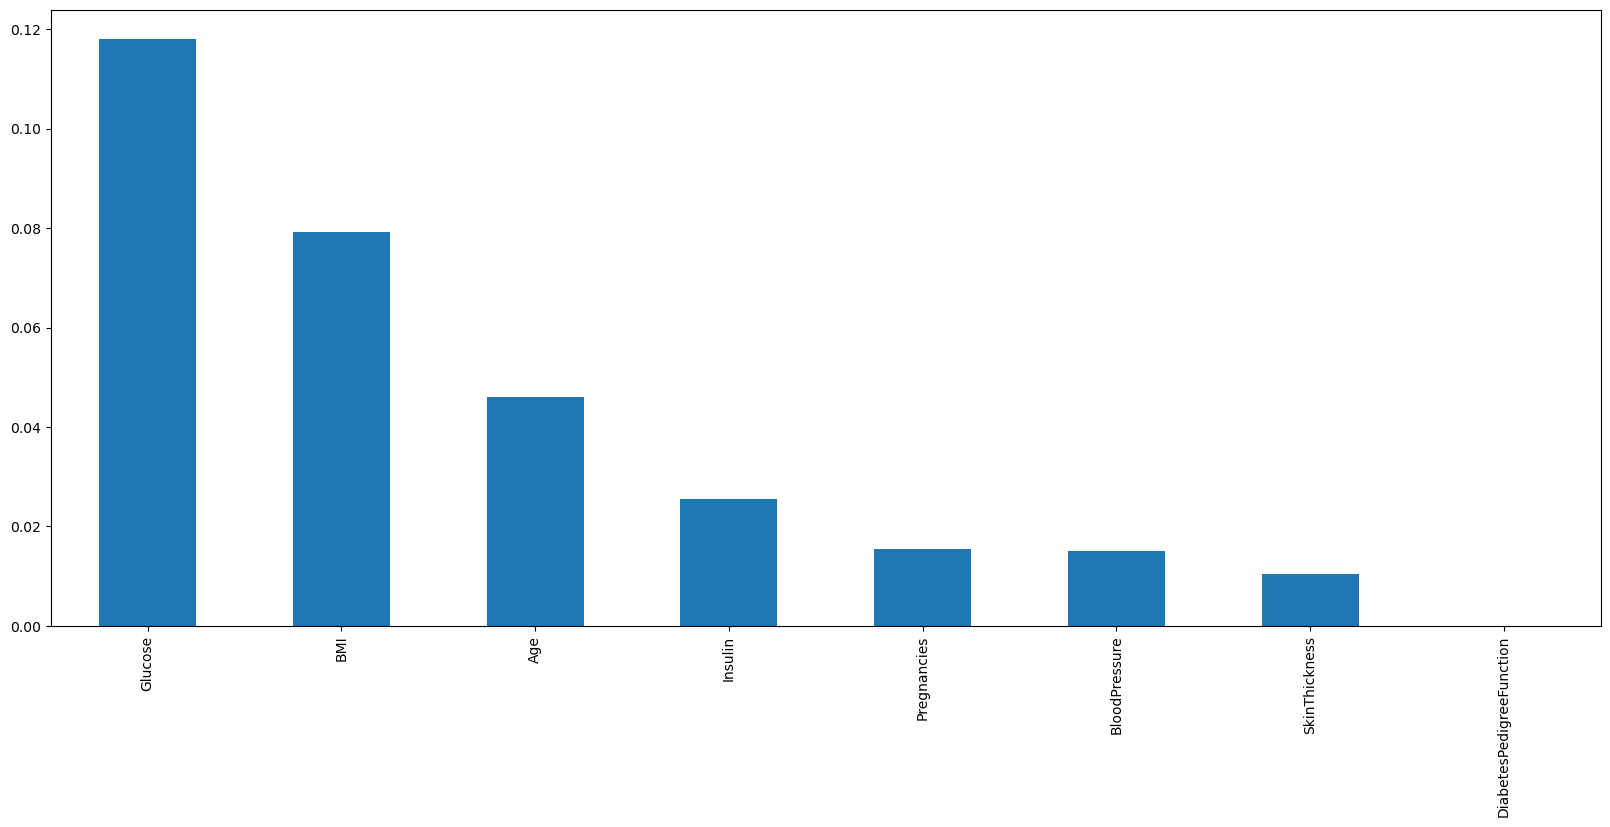

In [7]:
# Separate features and target
X = Pima_dataset.drop(columns='Outcome', axis=1)
y = Pima_dataset['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
mutual_info = pd.Series(mutual_info_classif(X_train, y_train, random_state = 0))
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending = False)
plt.figure(figsize = (20, 8))
mutual_info.sort_values(ascending = False).plot.bar()

In [8]:
print("Dropping DPF i.e. features not related to outcome")
Pima_dataset.drop(columns='DiabetesPedigreeFunction',axis=1, inplace=True)

Dropping DPF i.e. features not related to outcome


In [9]:
print("Predicting Insulin values for RTML Dataset (to be merged with PIMA) using XGBoost")
X = Pima_dataset.drop(columns='Insulin', axis=1)
y = Pima_dataset['Insulin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
XGB = XGBRegressor(max_depth=10,learning_rate=0.1)
XGB.fit(X_train,y_train)
predictions_xgb = XGB.predict(X_test)
final_mse = mean_squared_error(y_test, predictions_xgb)
final_rmse = np.sqrt(final_mse)
print("Insulin Regressor RMSE score:", final_rmse)

Predicting Insulin values for RTML Dataset (to be merged with PIMA) using XGBoost
Insulin Regressor RMSE score: 85.79124540997681


In [10]:
RTML_dataset = pd.read_excel('RTML without Insulin.xlsx')
print("Null values in features")
RTML_dataset.isna().sum()
print("Replacing Null Insulin feature from RTML with Predicted values")
X1 = RTML_dataset.drop(columns='Insulin', axis=1)
Y1 = XGB.predict(X1)
Y2= pd.DataFrame(Y1)
Y2.columns=['Insulin']
RTML_dataset.drop(columns='Insulin',axis=1, inplace=True)
Insulin_Merged = pd.concat([RTML_dataset, Y2], axis=1)
RTML_Merged = Insulin_Merged[["Pregnancies", "Glucose", "BloodPressure","SkinThickness","Insulin", "BMI", "Age","Outcome"]]
RTML_Merged.head

Null values in features
Replacing Null Insulin feature from RTML with Predicted values


<bound method NDFrame.head of      Pregnancies  Glucose  BloodPressure  SkinThickness     Insulin  \
0              5     88.2          106.0            4.8  204.799011   
1              6     73.8           74.0            7.5  211.457794   
2              1     86.4           87.0           18.4  119.480362   
3              1     97.2           71.0           15.0   67.878632   
4              5     90.0           96.0            7.6  220.453064   
..           ...      ...            ...            ...         ...   
104            3    187.2           79.0            9.4  177.282700   
105            2    149.4           82.0            9.8  218.581390   
106            1    163.8           84.0            6.5  192.582047   
107            4    167.4           86.0           11.7  242.816025   
108            2    171.0           78.0           10.8  189.431580   

           BMI  Age  Outcome  
0    14.794213   50        0  
1    24.851410   50        0  
2    41.621307   30     

In [11]:
print("Merging RTML with PIMA")
pieces = {"x": Pima_dataset, "y": RTML_Merged}
data = pd.concat(pieces)
print("Number of samples and features:", data.shape)

Merging RTML with PIMA
Number of samples and features: (877, 8)


In [12]:
# def detect_outliers_z_score(feature, threshold=3):    # outputs a list of values which are outliers for that feature
#     z_scores = np.abs((feature - feature.mean()) / feature.std())
#     outliers = np.where(z_scores > threshold)    # how does it store the actual value instead of normalized in the outliers list?
#     return outliers

# # Detect outliers for each feature using Z-score
# z_score_outliers = {}
# for column in X.columns:
#     outliers = detect_outliers_z_score(X[column])
#     z_score_outliers[column] = outliers[0]

# # Display the outliers
# for column, outliers in z_score_outliers.items():
#     print(f"Outliers in {column}: {outliers}")

def detect_outliers_iqr_in_col(data, threshold=1.5):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[((data < (Q1 - threshold * IQR)) | (data > (Q3 + threshold * IQR)))]    # What logic?
    return outliers

# Detect outliers for each feature using IQR
# iqr_outliers = {}
# for column in X.columns:
#     outliers = detect_outliers_iqr_in_col(X[column])
#     iqr_outliers[column] = outliers

# # Display the outliers
# for column, outliers in iqr_outliers.items():
#     print(f"Outliers in {column}: {outliers.index.tolist()}")    # why so much processing needed?

def remove_outliers_iqr(df,threshold=1.5):
    # Identify columns with numerical data
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Filter the dataframe to remove outliers
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

# Remove outliers using IQR
threshold = 1.5
data = remove_outliers_iqr(pd.DataFrame(data), threshold)
print(f"Number of samples and features after outliers removal using IQR(threshold = {threshold:.2f}):", data.shape)

Number of samples and features after outliers removal using IQR(threshold = 1.50): (698, 8)


In [13]:
# Separate features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Apply SMOTE
X_resampled, y_resampled = SMOTE(random_state=123).fit_resample(X, y)

# Normalize features
X_scaled = StandardScaler().fit_transform(X_resampled)

# Check original class distribution
print("Original class distribution:")
print(y.value_counts())
print()

# Check new class distribution
print("Class distribution after SMOTE:")
print(y_resampled.value_counts())
print()

# Verify the number of rows before and after SMOTE
print(f"Number of rows before SMOTE: {X.shape[0]}")
print(f"Number of rows after SMOTE: {X_resampled.shape[0]}")

Original class distribution:
Outcome
0    488
1    210
Name: count, dtype: int64

Class distribution after SMOTE:
Outcome
1    488
0    488
Name: count, dtype: int64

Number of rows before SMOTE: 698
Number of rows after SMOTE: 976


In [14]:
# Spliting Data into Training and Testing sets using Stratify 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size = 0.20, random_state = 42, stratify=y_resampled)

Model training time: 0.28 seconds
Confusion Matrix
[[80 18]
 [13 85]]
Accuracy: 0.842
Precision: 0.843
Recall: 0.842
F1-score: 0.842
CV Results =  81.17189143698717 % +/- 6.349588491337006 %


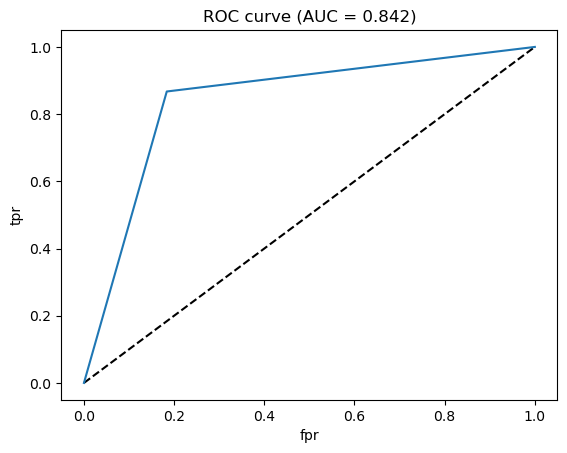

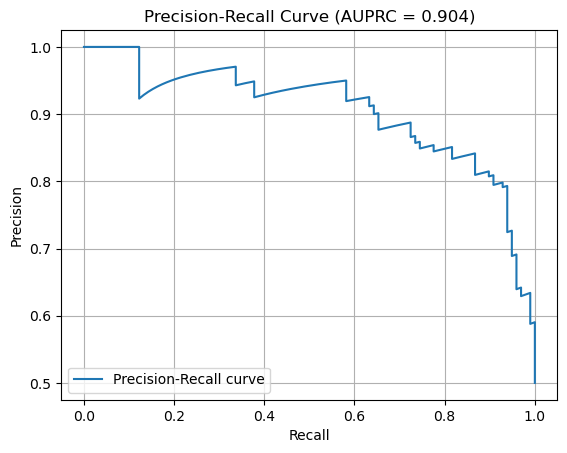

In [15]:
# # XGBost with metrics
# xg_class = XGBClassifier(
#     learning_rate=0.01,
#     n_estimators=1000,
#     max_depth=4,
#     min_child_weight=8,
#     subsample=0.6,
#     reg_alpha=0.005,
#     seed=27
# )

# # Train the model and Calculating running time without idle time
# training_time = timeit.timeit(lambda: xg_class.fit(X_train, y_train), number=1)

# # Make predictions
# y_pred = xg_class.predict(X_test)

# # calculate metrics of predictions
# print(f"Model training time: {training_time:.2f} seconds")
# print("Confusion Matrix")
# print(confusion_matrix(y_test,y_pred))

# # print(classification_report(y_test, y_pred))
# # Assuming y_pred contains probabilities, convert them to binary labels
# # y_pred_binary = (y_pred >= 0.5).astype(int)
# #Substitute y_pred with y_pred_binary if predicted values are not binary 
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred, average='weighted')
# recall = recall_score(y_test, y_pred, average='weighted')
# f1 = f1_score(y_test, y_pred, average='weighted')
# print("Accuracy: {:.3f}".format(accuracy))
# print("Precision: {:.3f}".format(precision))
# print("Recall: {:.3f}".format(recall))
# print("F1-score: {:.3f}".format(f1))

# # Score/Accuracy if Cross Validation
# skfold = StratifiedKFold(n_splits=10)
# cv_score = cross_val_score(xg_class,X_scaled,y_resampled,cv=skfold)
# print("CV Results = ", (np.mean(cv_score) *100),"% +/-",(np.std(cv_score)*100), "%")

# # Plot ROC curve
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# # plt.figure(figsize=(8, 6))
# plt.plot([0,1],[0,1],'k--')
# plt.plot(fpr,tpr, label='XGBoost')
# plt.xlabel('fpr')
# plt.ylabel('tpr')
# plt.title('ROC curve (AUC = {:.3f})'.format(roc_auc_score(y_test, y_pred)))
# plt.show()

# # Plot precision-recall curve
# y_probs = xg_class.predict_proba(X_test)[:, 1]
# precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
# # plt.figure(figsize=(8, 6))
# plt.plot(recall, precision, label='Precision-Recall curve')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve (AUPRC = {:.3f})'.format(auc(recall, precision)))
# plt.legend(loc="lower left")
# plt.grid(True)
# plt.show()


Model training time: 0.30 seconds
Confusion Matrix
[[80 18]
 [13 85]]
Accuracy: 0.842
Precision: 0.843
Recall: 0.842
F1-score: 0.842
Cross-validation Score: 81.37702503681885 +/- 6.539206100148083 %


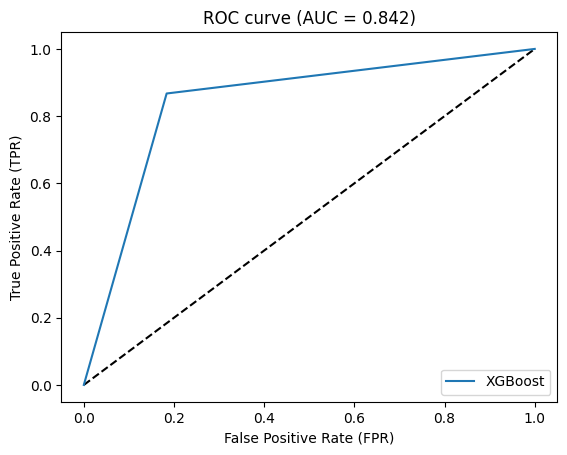

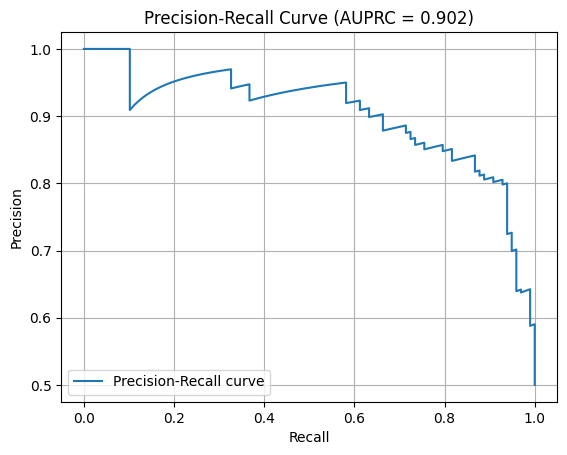

In [43]:
from xgboost import XGBClassifier
import timeit
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# XGBoost with metrics
xg_class = XGBClassifier(
    learning_rate=0.01,
    n_estimators=1000,
    max_depth=4,
    min_child_weight=8,
    subsample=0.6,
    reg_alpha=0.005,
    seed=27
)

# Train the model and calculate running time without idle time
training_time = timeit.timeit(lambda: xg_class.fit(X_train, y_train), number=1)

# Make predictions
y_pred = xg_class.predict(X_test)

# Calculate metrics of predictions
print(f"Model training time: {training_time:.2f} seconds")
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1-score: {:.3f}".format(f1))

# Score/Accuracy with Cross Validation
skfold = StratifiedKFold(n_splits=10)
cv_scores = cross_val_score(xg_class, X_scaled, y_resampled, cv=skfold)
print("Cross-validation Score:", (cv_scores.mean() * 100), "+/-", (cv_scores.std() * 100), "%")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='XGBoost')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve (AUC = {:.3f})'.format(roc_auc_score(y_test, y_pred)))
plt.legend(loc="lower right")
plt.show()

# Plot precision-recall curve
y_probs = xg_class.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (AUPRC = {:.3f})'.format(auc(recall, precision)))
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


C:\Users\Priyansh\miniconda3\envs\ML-Summer\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Priyansh\miniconda3\envs\ML-Summer\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best parameters found:  {'estimator': DecisionTreeClassifier(), 'learning_rate': 0.0001, 'n_estimators': 50}
Best cross-validation score:  0.7664416535845107
Model training + tuning time: 0.01 seconds
Confusion Matrix
[[77 21]
 [22 76]]
Accuracy: 0.781
Precision: 0.781
Recall: 0.781
F1-score: 0.781


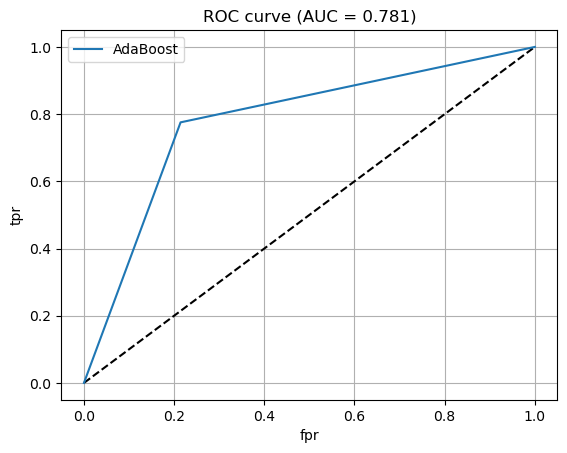

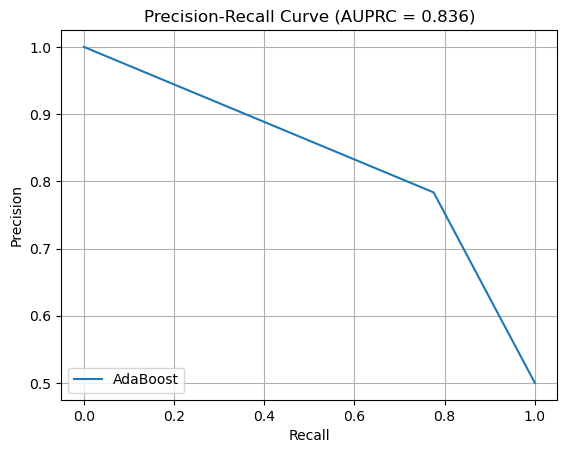

In [16]:
# # AdaBoost with metrics
# # Define the base estimator
# base = DecisionTreeClassifier()

# # Define the parameter grid
# param_grid = {
#     'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
#     'estimator': [base],
#     'n_estimators': [50, 100, 150]
# }

# # Initialize the AdaBoost classifier and Set up the grid search 
# ada = AdaBoostClassifier(random_state=42)
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(estimator=ada, param_grid=param_grid, cv=cv, n_jobs=-1)

# # Fit the model for all sets of hyperparameters and Calculate running time including hyperparameter tuning
# tuning_time = timeit.timeit(lambda: grid_search.fit(X_scaled, y_resampled), number=1)

# # Make predictions with the best model
# ada_best = grid_search.best_estimator_
# training_time = timeit.timeit(lambda: ada_best.fit(X_train, y_train), number=1)
# y_pred = ada_best.predict(X_test)

# # Print the best parameters and the corresponding score
# print("Best parameters found: ", grid_search.best_params_)
# print("Best cross-validation score: ", grid_search.best_score_)

# # calculate metrics of predictions
# print(f"Model training + tuning time: {training_time:.2f} seconds")
# print("Confusion Matrix")
# print(confusion_matrix(y_test,y_pred))
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred, average='weighted')
# recall = recall_score(y_test, y_pred, average='weighted')
# f1 = f1_score(y_test, y_pred, average='weighted')

# print("Accuracy: {:.3f}".format(accuracy))
# print("Precision: {:.3f}".format(precision))
# print("Recall: {:.3f}".format(recall))
# print("F1-score: {:.3f}".format(f1))

# # Plot ROC curve
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# # plt.figure(figsize=(8, 6))
# plt.plot([0,1],[0,1],'k--')
# plt.plot(fpr,tpr, label='AdaBoost')
# plt.xlabel('fpr')
# plt.ylabel('tpr')
# plt.title('ROC curve (AUC = {:.3f})'.format(roc_auc_score(y_test, y_pred)))
# plt.legend(loc="best")
# plt.grid(True)
# plt.show()

# # Plot precision-recall curve
# y_probs = ada_best.predict_proba(X_test)[:, 1]
# precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
# # plt.figure(figsize=(8, 6))
# plt.plot(recall, precision, label='AdaBoost')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve (AUPRC = {:.3f})'.format(auc(recall, precision)))
# plt.legend(loc="lower left")
# plt.grid(True)
# plt.show()


Best Hyperparameters: {'criterion': 'friedman_mse', 'learning_rate': 0.02999498316360058, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 713, 'subsample': 0.8603553891795411}
Best Cross-validation Score: 0.8243589743589743
Cross-validation Score: 82.78245318746056 +/- 4.012426914569281 %
Precision: 0.8572916666666667
Recall: 0.8571428571428571
F1-score: 0.8571279808393211
AUPRC: 0.9296418295478671
ROC AUC: 0.9252394835485215


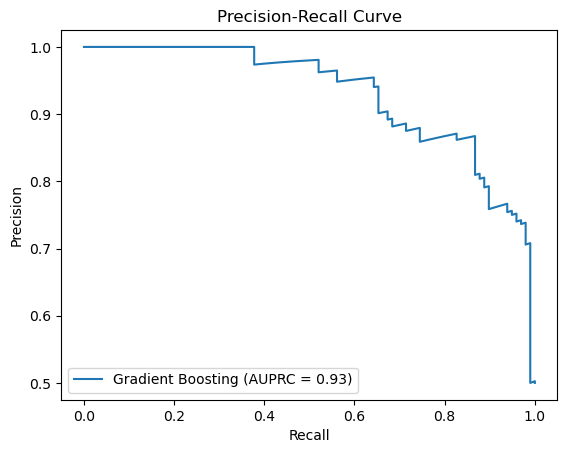

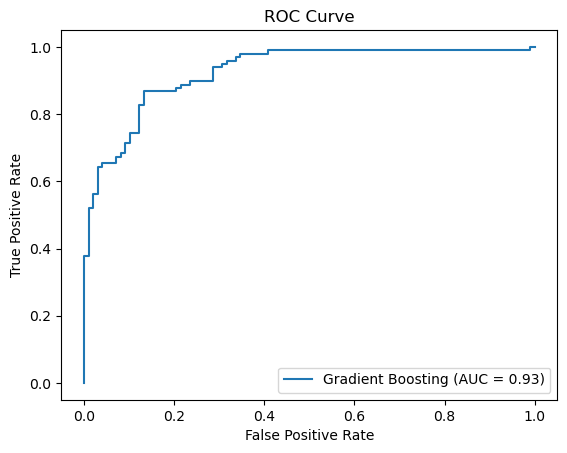

In [17]:

# # Gradient Boosting
# model = GradientBoostingClassifier(random_state=23)

# # Define the parameter distribution
# param_dist = {
#     'learning_rate': uniform(0.01, 0.2),
#     'n_estimators': randint(50, 1000),
#     'min_samples_split': randint(2, 32),
#     'min_samples_leaf': randint(1, 16),
#     'max_depth': randint(3, 10),
#     'subsample': uniform(0.6, 0.4),
#     'max_features': [None, 'sqrt', 'log2'],
#     'criterion': ['friedman_mse', 'squared_error']
# }

# # Set up the random search with cross-validation
# random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# # Fit the random search
# random_search.fit(X_train, y_train)

# # Print the best hyperparameters
# print("Best Hyperparameters:", random_search.best_params_)
# print("Best Cross-validation Score:", random_search.best_score_)

# # Evaluate the model using K-fold cross-validation with the best hyperparameters
# best_model = random_search.best_estimator_
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# cv_scores = cross_val_score(best_model, X_scaled, y_resampled, cv=skf, scoring='accuracy')

# # Print the cross-validation scores
# print("Cross-validation Score:", (cv_scores.mean() *100), "+/-", (cv_scores.std()*100), "%")

# # Make predictions
# y_pred = best_model.predict(X_test)
# y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# # Precision
# precision = precision_score(y_test, y_pred, average='weighted')
# print("Precision:", precision)

# # Recall
# recall = recall_score(y_test, y_pred, average='weighted')
# print("Recall:", recall)

# # F1-score
# f1 = f1_score(y_test, y_pred, average='weighted')
# print("F1-score:", f1)

# # Precision-Recall Curve and AUPRC
# precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
# auprc = auc(recall_curve, precision_curve)
# print("AUPRC:", auprc)

# # ROC Curve and AUC
# fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
# roc_auc = roc_auc_score(y_test, y_pred_proba)
# print("ROC AUC:", roc_auc)

# # Plot Precision-Recall Curve
# plt.figure()
# plt.plot(recall_curve, precision_curve, label=f'Gradient Boosting (AUPRC = {auprc:.2f})')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend(loc='best')
# plt.show()

# # Plot ROC Curve
# plt.figure()
# plt.plot(fpr, tpr, label=f'Gradient Boosting (AUC = {roc_auc:.2f})')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc='best')
# plt.show()


|   iter    |  target   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.7885    | 0.1186    | 9.655     | 7.588     | 638.8     | 0.0156    | 0.578     |
| 2         | 0.8013    | 0.02684   | 9.063     | 6.41      | 737.3     | 0.002058  | 0.985     |
| 3         | 0.8103    | 0.2514    | 4.486     | 2.636     | 265.1     | 0.03042   | 0.7624    |
| 4         | 0.7949    | 0.1353    | 5.039     | 6.507     | 225.5     | 0.02921   | 0.6832    |
| 5         | 0.7987    | 0.1423    | 8.496     | 2.797     | 562.8     | 0.05924   | 0.5232    |
| 6         | 0.8       | 0.1569    | 5.019     | 3.131     | 264.4     | 0.06866   | 0.6402    |
| 7         | 0.809     | 0.2074    | 4.014     | 2.65      | 265.1     | 0.03928   | 0.7355    |
| 8         | 0.8179    | 0.3       | 4.478     | 2.027     | 265.8     | 0.0       | 0.9442    |
| 9         | 0.8064

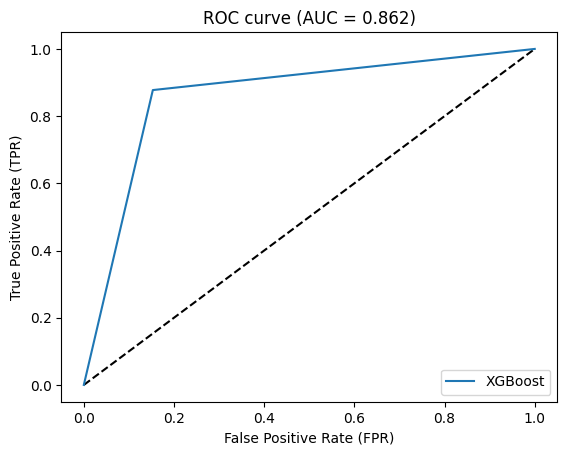

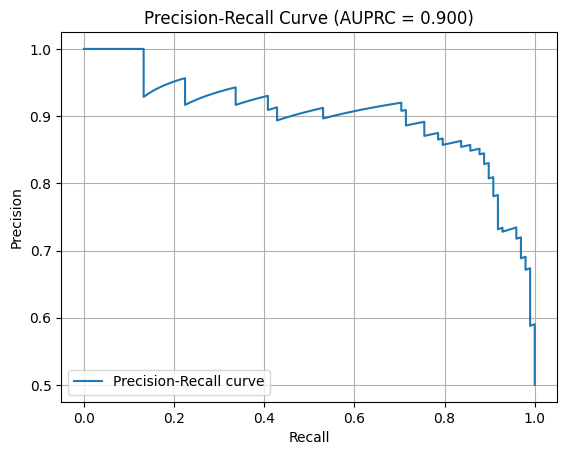

In [45]:
# !pip install bayesian-optimization
from xgboost import XGBClassifier
import timeit
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from bayes_opt import BayesianOptimization
import numpy as np
import matplotlib.pyplot as plt

# Function to optimize
def xgb_evaluate(max_depth, learning_rate, n_estimators, min_child_weight, subsample, reg_alpha):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'reg_alpha': reg_alpha,
        'seed': 27
    }
    
    xgb = XGBClassifier(**params)
    skfold = StratifiedKFold(n_splits=5)
    cv_result = cross_val_score(xgb, X_train, y_train, cv=skfold, scoring='accuracy').mean()
    
    return cv_result

# Define the parameter space for Bayesian Optimization
pbounds = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (100, 1000),
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1.0),
    'reg_alpha': (0, 0.1)
}

# Perform Bayesian Optimization
optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds=pbounds,
    random_state=42
)

optimizer.maximize(init_points=5, n_iter=25)

# Retrieve the best parameters
best_params = optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])

# Train the final model with the best parameters
xg_class = XGBClassifier(**best_params)
training_time = timeit.timeit(lambda: xg_class.fit(X_train, y_train), number=1)

# Make predictions
y_pred = xg_class.predict(X_test)

# Calculate metrics of predictions
print(f"Model training time: {training_time:.2f} seconds")
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1-score: {:.3f}".format(f1))

# Score/Accuracy with Cross Validation
skfold = StratifiedKFold(n_splits=10)
cv_scores = cross_val_score(xg_class, X_train, y_train, cv=skfold)
print("Cross-validation Score:", (cv_scores.mean() * 100), "+/-", (cv_scores.std() * 100), "%")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='XGBoost')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve (AUC = {:.3f})'.format(roc_auc_score(y_test, y_pred)))
plt.legend(loc="lower right")
plt.show()

# Plot precision-recall curve
y_probs = xg_class.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (AUPRC = {:.3f})'.format(auc(recall, precision)))
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


Best Hyperparameters: {'depth': 4, 'iterations': 3000, 'l2_leaf_reg': 1.0, 'learning_rate': 0.01, 'min_data_in_leaf': 1}
Best Cross-validation Score: 0.8102564102564103
Cross-validation Score: 82.58152745634335 +/- 4.167582236404542 %
Precision: 0.8520774757888159
Recall: 0.8520408163265306
F1-score: 0.85203696472732
AUPRC: 0.9256745376079318
ROC AUC: 0.92076218242399


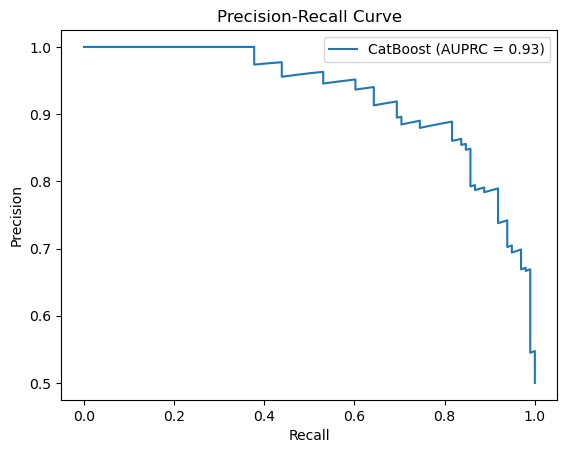

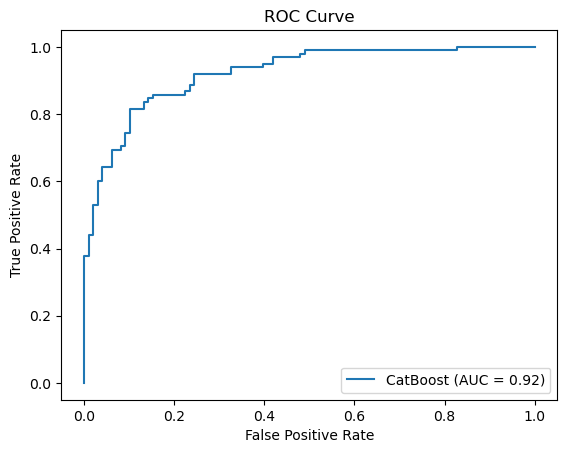

In [18]:
# CatBoost with metrics
model = CatBoostClassifier(random_state=42, silent=True)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.010, 0.004],
    'depth': [4],
    'l2_leaf_reg': [1.0],
    'min_data_in_leaf': [1, 4, 8, 16, 32],
    'iterations': [3000]
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1,error_score='raise')

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)

# Evaluate the model using K-fold cross-validation with the best hyperparameters
best_model = grid_search.best_estimator_
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_scaled, y_resampled, cv=skf, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation Score:", (cv_scores.mean() *100), "+/-", (cv_scores.std()*100), "%")

# Make predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Precision
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)

# F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score:", f1)

# Precision-Recall Curve and AUPRC
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
auprc = auc(recall_curve, precision_curve)
print("AUPRC:", auprc)

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC:", roc_auc)

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall_curve, precision_curve, label=f'CatBoost (AUPRC = {auprc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f'CatBoost (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

[LightGBM] [Info] Number of positive: 390, number of negative: 390
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 780, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best Hyperparameters: {'boosting_type': 'gbdt', 'class_weight': None, 'learning_rate': 0.01, 'min_child_samples': 4, 'min_child_weight': 0.01, 'n_estimators': 1500, 'num_leaves': 11, 'reg_lambda': 1.0}
Best Cross-validation Score: 0.8205128205128205
[LightGBM] [Info] Number of positive: 439, number of negative: 439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 949
[LightGBM] [Info] Number of data points in the train set:

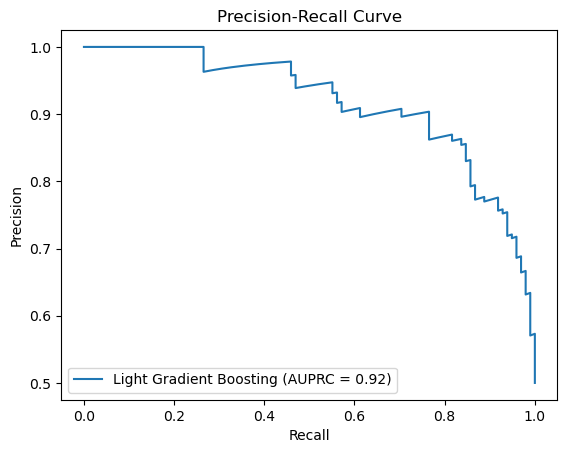

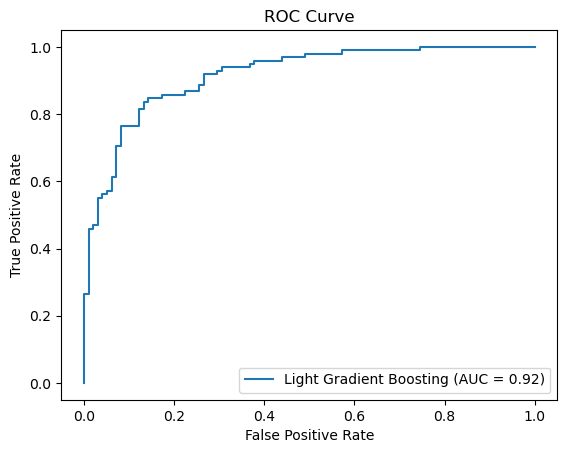

In [19]:
# LGBM with metrics
model = LGBMClassifier(random_state=124, n_jobs=6)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.010, 0.004],
    'num_leaves': [11],
    'reg_lambda': [1.0],
    'min_child_samples': [1, 4, 8, 16, 32],
    'min_child_weight': [0.01],
    'n_estimators': [1500],
    'boosting_type': ['gbdt'],
    'class_weight': [None, 'balanced']
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, error_score='raise')

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)

# Evaluate the model using K-fold cross-validation with the best hyperparameters
best_model = grid_search.best_estimator_
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_scaled, y_resampled, cv=skf, scoring='accuracy')

# Print the cross-validation scores
print(" Cross-validation Score:", (cv_scores.mean() *100), "+/-", (cv_scores.std()*100), "%")

# Make predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Precision
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)

# F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score:", f1)

# Precision-Recall Curve and AUPRC
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
auprc = auc(recall_curve, precision_curve)
print("AUPRC:", auprc)

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC:", roc_auc)

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall_curve, precision_curve, label=f'Light Gradient Boosting (AUPRC = {auprc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f'Light Gradient Boosting (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

Best Hyperparameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best Cross-validation Score: 0.8025641025641026
Cross-validation Score: 83.91331790448137 +/- 3.044705608348384 %
Precision: 0.8627997448979591
Recall: 0.8622448979591837
F1-score: 0.8623202975771589
AUPRC: 0.9480974310511738
ROC AUC: 0.9408080175383652


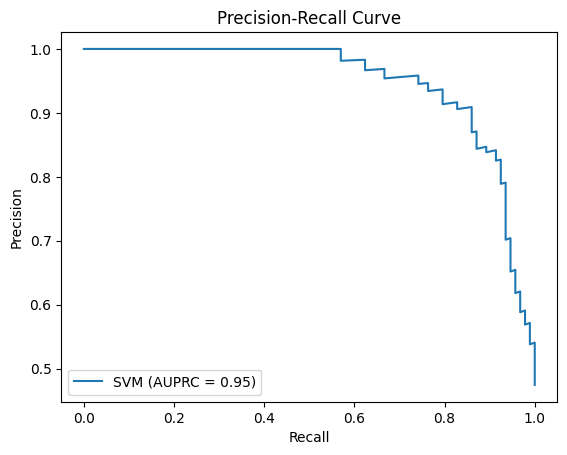

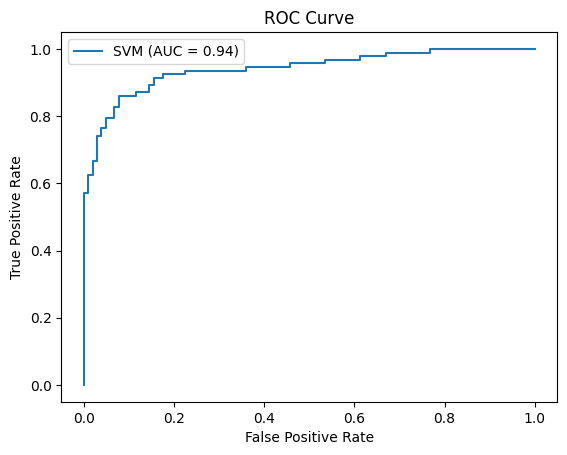

Cross-validation Score: 83.91331790448137 +/- 3.044705608348384 %


In [42]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc
# from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
# from sklearn.svm import SVC
# from timeit import timeit

# # Ensure the data arrays have consistent lengths
# assert X_scaled.shape[0] == y_resampled.shape[0], "X_scaled and y must have the same number of samples"

# # Split the data
# X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

# # Define the SVM model
# svm_model = SVC(probability=True, random_state=42)

# # Define the parameter grid for SVM
# param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf'],
#     'gamma': [1, 0.1, 0.01, 0.001]
# }

# # Set up the grid search with cross-validation
# grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# # Fit the grid search
# grid_search.fit(X_train_svm, y_train_svm)

# # Print the best hyperparameters
# print("Best Hyperparameters:", grid_search.best_params_)
# print("Best Cross-validation Score:", grid_search.best_score_)

# # Evaluate the model using K-fold cross-validation with the best hyperparameters
# best_model = grid_search.best_estimator_
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# cv_scores = cross_val_score(best_model, X_scaled, y_resampled, cv=skf, scoring='accuracy')

# # Print the cross-validation scores
# print("Cross-validation Score:", (cv_scores.mean() * 100), "+/-", (cv_scores.std() * 100), "%")

# # Make predictions
# y_pred = best_model.predict(X_test_svm)
# y_pred_proba = best_model.predict_proba(X_test_svm)[:, 1]

# # Precision
# precision = precision_score(y_test_svm, y_pred, average='weighted')
# print("Precision:", precision)

# # Recall
# recall = recall_score(y_test_svm, y_pred, average='weighted')
# print("Recall:", recall)

# # F1-score
# f1 = f1_score(y_test_svm, y_pred, average='weighted')
# print("F1-score:", f1)

# # Precision-Recall Curve and AUPRC
# precision_curve, recall_curve, _ = precision_recall_curve(y_test_svm, y_pred_proba, pos_label=1)
# auprc = auc(recall_curve, precision_curve)
# print("AUPRC:", auprc)

# # ROC Curve and AUC
# fpr, tpr, _ = roc_curve(y_test_svm, y_pred_proba, pos_label=1)
# roc_auc = roc_auc_score(y_test_svm, y_pred_proba)
# print("ROC AUC:", roc_auc)

# # Plot Precision-Recall Curve
# plt.figure()
# plt.plot(recall_curve, precision_curve, label=f'SVM (AUPRC = {auprc:.2f})')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend(loc='best')
# plt.show()

# # Plot ROC Curve
# plt.figure()
# plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc:.2f})')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc='best')
# plt.show()
# cv_results = grid_search.cv_results_

# cv_scores = cross_val_score(best_model, X_scaled, y_resampled, cv=skf, scoring='accuracy')

# # Print the cross-validation scores
# print("Cross-validation Score:", (cv_scores.mean() *100), "+/-", (cv_scores.std()*100), "%")

In [46]:
!pip install bayesian-optimization


|   iter    |  target   |     C     |   gamma   |  kernel   |
-------------------------------------------------------------
| 1         | 0.7487    | 3.808     | 0.9508    | 0.732     |
| 2         | 0.7487    | 6.027     | 0.1569    | 0.156     |
| 3         | 0.7462    | 0.675     | 0.8663    | 0.6011    |
| 4         | 0.7487    | 7.11      | 0.02156   | 0.9699    |
| 5         | 0.7487    | 8.341     | 0.2131    | 0.1818    |
| 6         | 0.8026    | 10.0      | 1.0       | 1.0       |
| 7         | 0.7487    | 10.0      | 1.0       | 0.2425    |
| 8         | 0.7449    | 0.4548    | 0.5652    | 0.7525    |
| 9         | 0.7487    | 10.0      | 0.9998    | 0.9998    |
| 10        | 0.7487    | 10.0      | 1.0       | 1.0       |
| 11        | 0.8026    | 10.0      | 1.0       | 1.0       |
| 12        | 0.7487    | 8.008     | 0.09496   | 0.7018    |
| 13        | 0.7487    | 3.244     | 0.8911    | 0.1363    |
| 14        | 0.7487    | 1.363     | 0.6185    | 0.3787    |
| 15    

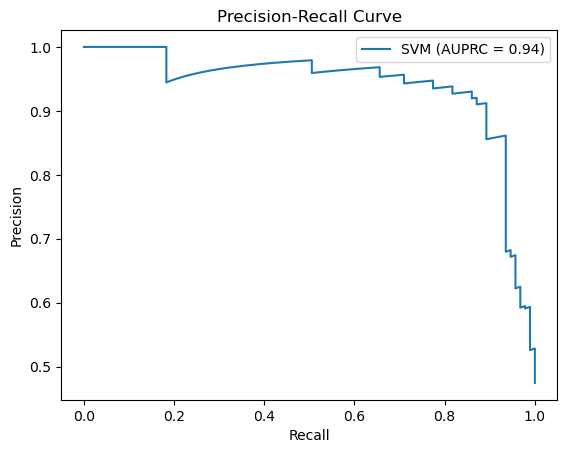

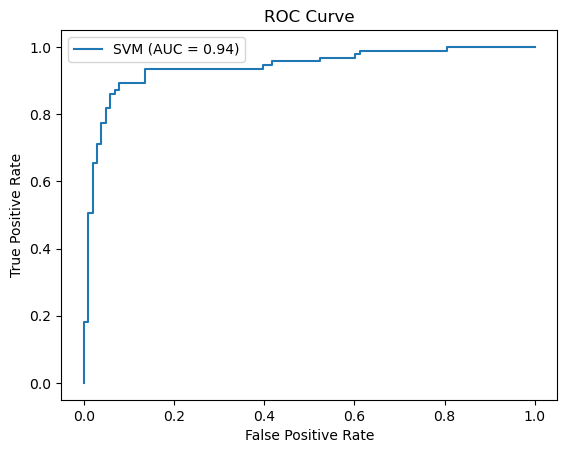

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from bayes_opt import BayesianOptimization
from timeit import timeit

# Ensure the data arrays have consistent lengths
assert X_scaled.shape[0] == y_resampled.shape[0], "X_scaled and y_resampled must have the same number of samples"

# Split the data
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

# Function to optimize
def svm_evaluate(C, gamma, kernel):
    kernel = ['linear', 'rbf'][int(kernel)]  # Convert kernel index to actual string
    svm_model = SVC(C=C, gamma=gamma, kernel=kernel, probability=True, random_state=42)
    skfold = StratifiedKFold(n_splits=5)
    cv_result = cross_val_score(svm_model, X_train_svm, y_train_svm, cv=skfold, scoring='accuracy').mean()
    return cv_result

# Define the parameter space for Bayesian Optimization
pbounds = {
    'C': (0.1, 10),
    'gamma': (0.001, 1),
    'kernel': (0, 1)  # 0 for 'linear', 1 for 'rbf'
}

# Perform Bayesian Optimization
optimizer = BayesianOptimization(
    f=svm_evaluate,
    pbounds=pbounds,
    random_state=42
)

optimizer.maximize(init_points=5, n_iter=25)

# Retrieve the best parameters
best_params = optimizer.max['params']
best_params['kernel'] = ['linear', 'rbf'][int(best_params['kernel'])]  # Convert back to string

# Train the final model with the best parameters
svm_model = SVC(C=best_params['C'], gamma=best_params['gamma'], kernel=best_params['kernel'], probability=True, random_state=42)
training_time = timeit(lambda: svm_model.fit(X_train_svm, y_train_svm), number=1)

# Make predictions
y_pred = svm_model.predict(X_test_svm)
y_pred_proba = svm_model.predict_proba(X_test_svm)[:, 1]

# Calculate metrics of predictions
print(f"Model training time: {training_time:.2f} seconds")
print("Confusion Matrix")
print(confusion_matrix(y_test_svm, y_pred))

accuracy = accuracy_score(y_test_svm, y_pred)
precision = precision_score(y_test_svm, y_pred, average='weighted')
recall = recall_score(y_test_svm, y_pred, average='weighted')
f1 = f1_score(y_test_svm, y_pred, average='weighted')

print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1-score: {:.3f}".format(f1))

# Score/Accuracy with Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_model, X_scaled, y_resampled, cv=skf, scoring='accuracy')
print("Cross-validation Score:", (cv_scores.mean() * 100), "+/-", (cv_scores.std() * 100), "%")

# Precision-Recall Curve and AUPRC
precision_curve, recall_curve, _ = precision_recall_curve(y_test_svm, y_pred_proba, pos_label=1)
auprc = auc(recall_curve, precision_curve)
print("AUPRC:", auprc)

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test_svm, y_pred_proba, pos_label=1)
roc_auc = roc_auc_score(y_test_svm, y_pred_proba)
print("ROC AUC:", roc_auc)

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall_curve, precision_curve, label=f'SVM (AUPRC = {auprc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 40, 'bootstrap': False}
Best Cross-validation Score: 0.8166666666666668
Cross-validation Score: 85.65221965074691 +/- 3.798310870769614 %
Confusion Matrix
[[90 13]
 [10 83]]
Accuracy: 0.883
Precision: 0.883
Recall: 0.883
F1-score: 0.883
AUPRC: 0.9478010765372985
ROC AUC: 0.9447750287086336


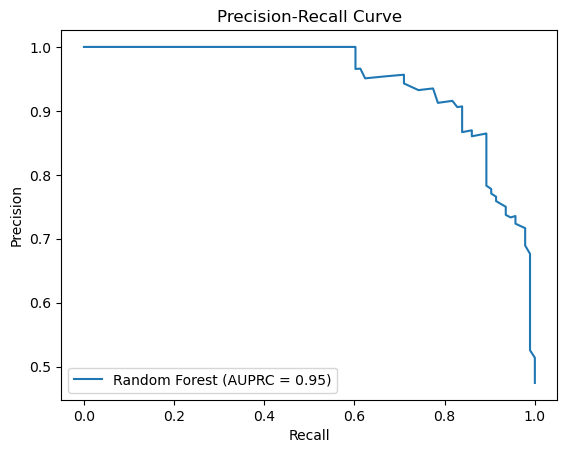

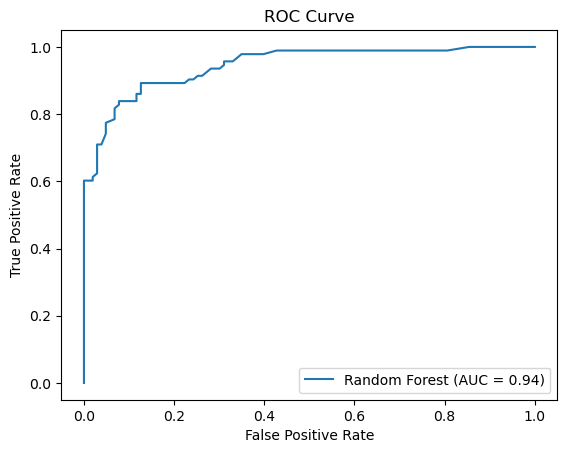

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid for Random Forest
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Set up the random search with cross-validation
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search
random_search.fit(X_train_svm, y_train_svm)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)
print("Best Cross-validation Score:", random_search.best_score_)

# Evaluate the model using K-fold cross-validation with the best hyperparameters
best_model = random_search.best_estimator_
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_scaled, y_resampled, cv=skf, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation Score:", (cv_scores.mean() * 100), "+/-", (cv_scores.std() * 100), "%")

# Make predictions
y_pred = best_model.predict(X_test_svm)
y_pred_proba = best_model.predict_proba(X_test_svm)[:, 1]

# Calculate metrics of predictions
print("Confusion Matrix")
print(confusion_matrix(y_test_svm, y_pred))

accuracy = accuracy_score(y_test_svm, y_pred)
precision = precision_score(y_test_svm, y_pred, average='weighted')
recall = recall_score(y_test_svm, y_pred, average='weighted')
f1 = f1_score(y_test_svm, y_pred, average='weighted')

print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1-score: {:.3f}".format(f1))

# Precision-Recall Curve and AUPRC
precision_curve, recall_curve, _ = precision_recall_curve(y_test_svm, y_pred_proba, pos_label=1)
auprc = auc(recall_curve, precision_curve)
print("AUPRC:", auprc)

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test_svm, y_pred_proba, pos_label=1)
roc_auc = roc_auc_score(y_test_svm, y_pred_proba)
print("ROC AUC:", roc_auc)

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall_curve, precision_curve, label=f'Random Forest (AUPRC = {auprc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


|   iter    |  target   | bootstrap | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | 0.8026    | 0.3745    | 38.52     | 3.196     | 6.789     | 162.4     |
| 2         | 0.7949    | 0.156     | 11.74     | 3.599     | 6.809     | 383.2     |
| 3         | 0.8026    | 0.02058   | 39.1      | 3.497     | 3.699     | 172.7     |
| 4         | 0.8051    | 0.1834    | 19.13     | 2.574     | 5.456     | 216.5     |
| 5         | 0.8077    | 0.6119    | 14.18     | 1.876     | 4.931     | 282.4     |
| 6         | 0.8026    | 0.7852    | 15.99     | 2.543     | 6.739     | 118.6     |
| 7         | 0.8       | 0.6075    | 15.12     | 1.195     | 9.591     | 486.3     |
| 8         | 0.8038    | 0.8084    | 19.14     | 1.293     | 7.474     | 276.1     |
| 9         | 0.8077    | 0.122     | 24.86     | 1.103     | 9.275     | 203.5     |
| 10        | 0.7949    | 0.6625    | 19.35     | 2.56

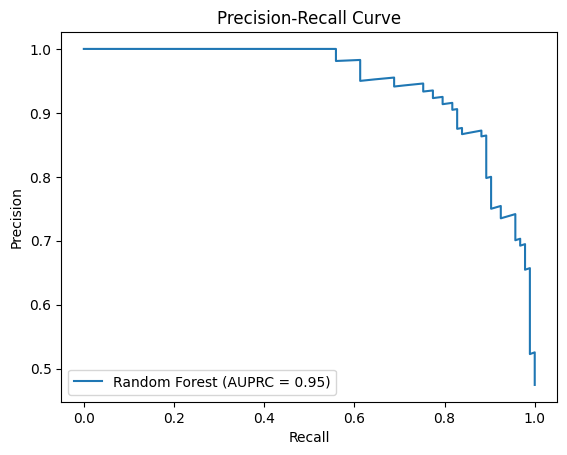

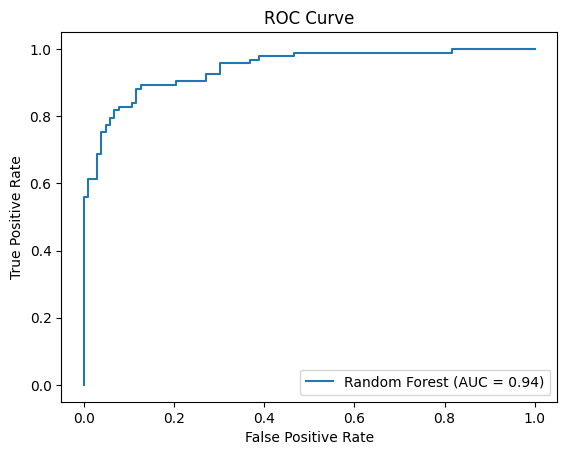

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from bayes_opt import BayesianOptimization

# Ensure the data arrays have consistent lengths
assert X_scaled.shape[0] == y_resampled.shape[0], "X_scaled and y_resampled must have the same number of samples"

# Split the data
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define the function to optimize
def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf, bootstrap):
    rf_model = RandomForestClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        bootstrap=bootstrap > 0.5,
        random_state=42
    )
    cv_scores = cross_val_score(rf_model, X_train_svm, y_train_svm, cv=5, scoring='accuracy')
    return cv_scores.mean()

# Set up the Bayesian optimizer
pbounds = {
    'n_estimators': (100, 500),
    'max_depth': (10, 40),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4),
    'bootstrap': (0, 1)
}

optimizer = BayesianOptimization(
    f=rf_cv,
    pbounds=pbounds,
    random_state=42
)

# Run the optimizer
optimizer.maximize(
    init_points=10,
    n_iter=30
)

# Print the best hyperparameters
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_samples_split'] = int(best_params['min_samples_split'])
best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])
best_params['bootstrap'] = best_params['bootstrap'] > 0.5

print("Best Hyperparameters:", best_params)

# Train the best model with the best hyperparameters
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train_svm, y_train_svm)

# Evaluate the model using K-fold cross-validation with the best hyperparameters
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_scaled, y_resampled, cv=skf, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation Score:", (cv_scores.mean() * 100), "+/-", (cv_scores.std() * 100), "%")

# Make predictions
y_pred = best_model.predict(X_test_svm)
y_pred_proba = best_model.predict_proba(X_test_svm)[:, 1]

# Calculate metrics of predictions
print("Confusion Matrix")
print(confusion_matrix(y_test_svm, y_pred))

accuracy = accuracy_score(y_test_svm, y_pred)
precision = precision_score(y_test_svm, y_pred, average='weighted')
recall = recall_score(y_test_svm, y_pred, average='weighted')
f1 = f1_score(y_test_svm, y_pred, average='weighted')

print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1-score: {:.3f}".format(f1))

# Precision-Recall Curve and AUPRC
precision_curve, recall_curve, _ = precision_recall_curve(y_test_svm, y_pred_proba, pos_label=1)
auprc = auc(recall_curve, precision_curve)
print("AUPRC:", auprc)

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test_svm, y_pred_proba, pos_label=1)
roc_auc = roc_auc_score(y_test_svm, y_pred_proba)
print("ROC AUC:", roc_auc)

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall_curve, precision_curve, label=f'Random Forest (AUPRC = {auprc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()
